In [243]:
import pandas as pd
import numpy as np
import os
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import *
from collections import Counter

In [244]:
class HierarchicalClustering:
    def __init__(self, state: str):
        self.state = state
        self.ACs = []
        for ac_name in os.listdir('./ACs'):
            if state in ac_name:
                ac_i = pd.read_pickle('./ACs/'+ac_name)
                self.ACs.append(ac_i)
        self.n_rows = len(self.ACs[0])

    def get_X_Y(self, row: int) -> (pd.DataFrame, pd.DataFrame):
        data = []
        for AC in self.ACs:
            AC = pd.DataFrame(AC)
            data.append(AC.iloc[row,:].tolist())
        data = pd.DataFrame(data).reset_index(drop=True)
        X = data.iloc[:,1:]
        Y = data.iloc[:,0]
        
        return X, Y    
    
    def cluster(self, X: pd.DataFrame, Y: pd.Series, method='ward', threashold = 0.8, no_plot=True) -> (list, list, list):
        dendrogram = sch.dendrogram(sch.linkage(X, method=method), no_plot=no_plot)
        
        leaves = dendrogram['leaves']
        leaves_color_list = dendrogram['leaves_color_list']
        color_counts = Counter(dendrogram['leaves_color_list'])
        
        n_leaves = len(leaves_color_list)
        
        anomaly_score = [0]*n_leaves
        yhat = [0]*n_leaves
        for i, color in zip(leaves, leaves_color_list):
            anomaly_score[i] = 1 - (color_counts[color]/n_leaves)
            
            if anomaly_score[i] > threashold: # Under 1/3 are the cluster
                yhat[i] = 1
            
        return (yhat, Y.astype(int).tolist(), anomaly_score)
    
    def cluster_all(self, method='ward', threashold = 0.8) -> (list, list, list):
        
        yhat, y, anomaly_score = [], [], []
        
        for row in range(self.n_rows):
            X, Y = hc.get_X_Y(row)
            if sum(Y) > len(Y)//2: continue
                
            yhat_row, y_row, anomaly_score_row = hc.cluster(X,Y,method,threashold)
            
            y += y_row
            anomaly_score += anomaly_score_row
            yhat += yhat_row
            
        # accuracy: (tp + tn) / (p + n)
        accuracy = accuracy_score(y, yhat)
        print('Accuracy: %f' % accuracy)
        # precision tp / (tp + fp)
        precision = precision_score(y, yhat)
        print('Precision: %f' % precision)
        # recall: tp / (tp + fn)
        recall = recall_score(y, yhat)
        print('Recall: %f' % recall)
        # f1: 2 tp / (2 tp + fp + fn)
        f1 = f1_score(y, yhat)
        print('F1 score: %f' % f1)
        # AUC
        fpr, tpr, thresholds = roc_curve(y_row, anomaly_score_row)
        AUC = auc(fpr, tpr)
        print('AUC score: %f' % AUC)
        return yhat, y, anomaly_score
        

In [245]:
hc = HierarchicalClustering('harmonic_low_18_cold_fullyOpen')
# for threashold in [0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95]:
for threashold in [0.8, 0.85, 0.9, 0.95]:
    print('Threashold : ' + str(threashold))
    hc.cluster_all()
    print('--------------------')

Threashold : 0.8
Accuracy: 0.904283
Precision: 0.506303
Recall: 0.358631
F1 score: 0.419861
AUC score: 1.000000
--------------------
Threashold : 0.85
Accuracy: 0.904283
Precision: 0.506303
Recall: 0.358631
F1 score: 0.419861
AUC score: 1.000000
--------------------
Threashold : 0.9
Accuracy: 0.904283
Precision: 0.506303
Recall: 0.358631
F1 score: 0.419861
AUC score: 1.000000
--------------------
Threashold : 0.95
Accuracy: 0.904283
Precision: 0.506303
Recall: 0.358631
F1 score: 0.419861
AUC score: 1.000000
--------------------


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
0.0


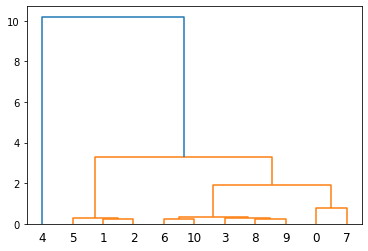

In [222]:
row = 300
X, Y = hc.get_X_Y(row)
yhat_row, y_row, anomaly_score_row = hc.cluster(X,Y,no_plot=False)
print(yhat_row)
print(y_row)